# Imports

Works with
```
python 3.7.16 
tf 1.15.0
h5py 3.8.0
deeplift 0.6.12.0
```

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers as layers
from deeplift.conversion import kerasapi_conversion as kc
import sys, h5py, deeplift
print('python', sys.version)
print('tf', tf.__version__)
print('h5py', h5py.__version__)
print('deeplift', deeplift.__version__)

python 3.7.16 (default, Jan 17 2023, 22:20:44) 
[GCC 11.2.0]
tf 1.15.0
h5py 3.8.0
deeplift 0.6.12.0


In [2]:
import deeplift_utils

# Constants

In [6]:
REP = 'out'
MODEL_DIR = 'models'
K = 10 # number of samples for the random reference
N_BEST_GENES = 70
DATA_PATH = '~/data/nabid/pilot2filtered.csv'
MODEL_DIR = 'models/'

In [7]:
rng=np.random.default_rng()

# Data

In [8]:
data = deeplift_utils.get_p53(
    dataset_path=DATA_PATH, labelled=True, normalize='standard', thresh=2e-2, )

382.69156289100647 Read csv
114.67538571357727 remove_cst
1.33327054977417 normalize


In [9]:
data = data[data.allele.isin(['wt','mut'])]
X = data.iloc[:,:-3].to_numpy()
Y = pd.get_dummies(data.allele).astype(int).to_numpy()
X_train, X_test , Y_train, Y_test = train_test_split(X,Y, train_size=0.8)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train , train_size=0.9)

# Training and saving model

In [10]:
model = deeplift_utils.make_model(X, shape=[70]*2)
hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                 epochs=4
                 )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2024-04-23 18:22:32.714683: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-23 18:22:32.714822: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-23 18:22:32.714889: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lonicera): /proc/driver/nvidia/version does not exist
2024-04-23 18:22:32.720475: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-04-23 18:22:32.749908: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2611200000 Hz
2024-04-23 18:22:32.751317: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x22e03d0 initialized for platform Host (this does not guarantee that

Train on 2052 samples, validate on 570 samples
Epoch 1/4
2052/2052 [==============================] - 1s 388us/sample - loss: 0.3421 - categorical_accuracy: 0.8402 - val_loss: 0.2267 - val_categorical_accuracy: 0.9088
Epoch 2/4
2052/2052 [==============================] - 1s 322us/sample - loss: 0.2094 - categorical_accuracy: 0.9196 - val_loss: 0.2184 - val_categorical_accuracy: 0.9105
Epoch 3/4
2052/2052 [==============================] - 1s 316us/sample - loss: 0.1872 - categorical_accuracy: 0.9220 - val_loss: 0.2476 - val_categorical_accuracy: 0.9105
Epoch 4/4
2052/2052 [==============================] - 1s 376us/sample - loss: 0.1685 - categorical_accuracy: 0.9288 - val_loss: 0.2234 - val_categorical_accuracy: 0.9211


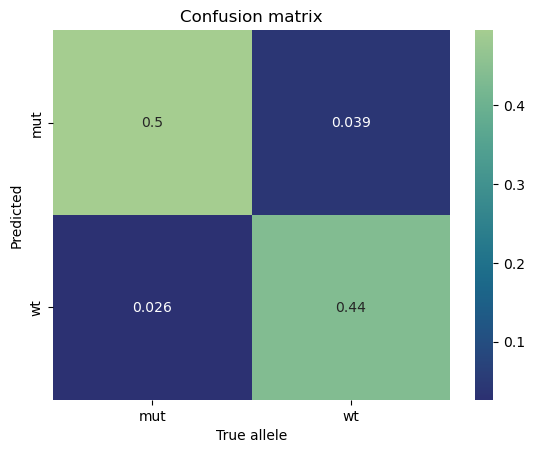

0.9342105263157894


In [11]:
Y_pred = model.predict(X_valid)
Y_pred = pd.DataFrame(np.where(Y_pred>0.5, 1, 0),  columns=['mut', 'wt'])
C = deeplift_utils.confusion_matrix(pd.DataFrame(Y_valid, columns=['mut', 'wt']), Y_pred)
print(C.iloc[0,0]+C.iloc[1,1])

In [12]:
config = model.to_json()
tf.keras.models.save_model(model,f'{MODEL_DIR}/model.h5')
with open(f'{MODEL_DIR}/cfg.json', 'w') as writer:
    writer.write(config)

# Converting model to DeepLIFT

In [14]:
converted = kc.convert_model_from_saved_files(
    f'{MODEL_DIR}/model.h5', json_file=f'{MODEL_DIR}/cfg.json')

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault

For layer 1 the preceding linear layer is preact_1 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 2 the preceding linear layer is preact_2 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel


Heads-up: I assume softmax is the output layer, not an intermediate one; if it's an intermediate layer, please let me know and I will prioritise that use-case
For layer 3 the preceding linear layer is preact_3 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel


In [15]:
contribs_f = converted.get_target_contribs_func(
                            find_scores_layer_idx=0,
                            target_layer_idx=-2)

MAKING A SESSION







# Cells and references

In [16]:
Y_pred = model.predict(X)
# subgroups along the model's prediction
Xpos = X[Y_pred[:,0]>0.5]
Xneg = X[Y_pred[:,0]<0.5]
# sampling along true alleles for the reference. could also do mean over the group
Rpos = lambda n: rng.choice(X[Y[:,0]==1], replace=True, size=n)
Rneg = lambda n: rng.choice(X[Y[:,0]==0], replace=True, size=n)

In [17]:
imp = []
for (ref,i) in zip([Rpos, Rneg], ['+','-']) : 
    sample,j = (Xpos, '+') if i == '-' else (Xneg, '-')
    for ix in range(K):
        A = np.array(contribs_f(task_idx=0,
                                    input_data_list=[sample],
                                    batch_size=10,
                                    progress_update=10000,
                                    input_references_list=[ref(sample.shape[0])])) 
        imp.append([*np.abs(A).mean(axis=0)])
scores = pd.DataFrame(imp, columns=[ *data.columns[:-3]])
scores = scores.mean(axis=0)


Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0


In [18]:
best_genes = scores.sort_values(ascending=False).iloc[:N_BEST_GENES]

In [19]:
scores

ENSG00000241860    0.000401
ENSG00000237491    0.000252
ENSG00000228794    0.000498
ENSG00000225880    0.000153
ENSG00000230699    0.000440
                     ...   
ENSG00000278704    0.000278
ENSG00000276256    0.000412
ENSG00000278384    0.000525
ENSG00000271254    0.000814
ENSG00000278817    0.000630
Length: 12931, dtype: float32

In [20]:
best_genes

ENSG00000054148    0.025160
ENSG00000087088    0.020780
ENSG00000185088    0.018010
ENSG00000161513    0.016189
ENSG00000078237    0.015826
                     ...   
ENSG00000139433    0.007441
ENSG00000196220    0.007410
ENSG00000120889    0.007331
ENSG00000182220    0.007322
ENSG00000188157    0.007300
Length: 70, dtype: float32

# Importance results

Text(0.5, 1.0, 'Contribution scores distribution')

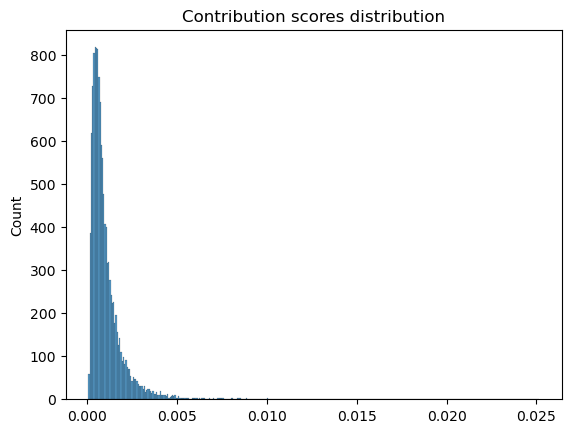

In [21]:
sns.histplot(scores)
# plt.yscale('log')
plt.title('Contribution scores distribution')


In [22]:
df = data[best_genes.index].copy() #silence warning
df['allele'] = data['allele'] 
df = df.melt(value_name='Expression', var_name='gene', id_vars='allele')

In [23]:
df

,allele,gene,Expression
0,mut,ENSG00000054148,-0.386866
1,wt,ENSG00000054148,-1.129578
2,wt,ENSG00000054148,0.541523
3,mut,ENSG00000054148,0.912879
4,mut,ENSG00000054148,-0.386866
...,...,...,...
199495,wt,ENSG00000188157,-0.409958
199496,wt,ENSG00000188157,-0.409958
199497,mut,ENSG00000188157,-0.409958
199498,wt,ENSG00000188157,1.647813


<AxesSubplot:xlabel='gene', ylabel='Expression'>

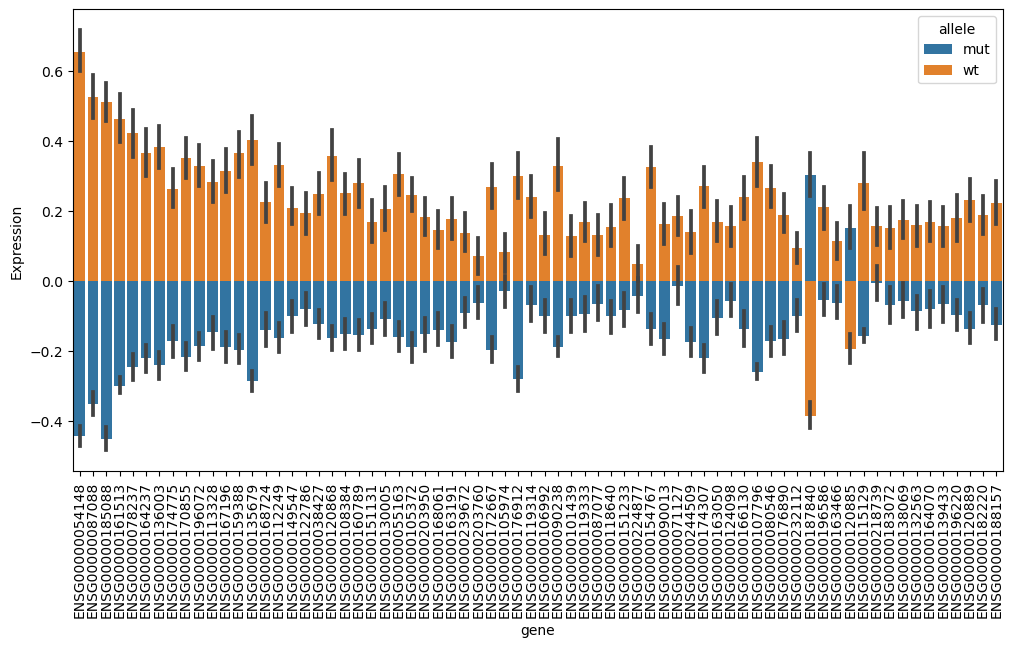

In [24]:
plt.gcf().set_size_inches([12,6])
plt.xticks(rotation=90)
sns.barplot(data=df, hue='allele', x='gene', y='Expression', order=best_genes.index, dodge=False)
# plt.savefig(TEMP_PATH)

In [25]:
df

,allele,gene,Expression
0,mut,ENSG00000054148,-0.386866
1,wt,ENSG00000054148,-1.129578
2,wt,ENSG00000054148,0.541523
3,mut,ENSG00000054148,0.912879
4,mut,ENSG00000054148,-0.386866
...,...,...,...
199495,wt,ENSG00000188157,-0.409958
199496,wt,ENSG00000188157,-0.409958
199497,mut,ENSG00000188157,-0.409958
199498,wt,ENSG00000188157,1.647813


# Saving results

In [26]:
best_genes.to_csv(f'{REP}/{N_BEST_GENES}_best_genes.csv',header=['score'] )